In [143]:
# The code was removed by Watson Studio for sharing.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.17.0-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00   1.06 MB/s
geopy-1.17.0-p 100% |################################| Time: 0:00:00   1.59 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.0-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00   2.90 MB/s
branca-0.3.0-p 100% |################################| Time: 0:00:00  25.20 MB/s
vincent-0.4.4- 100% |###################

# 1.  Explore Neiborhoods in Toronto

## 1.1 Import and exlpore dataset

#### Import Neiborhoods name of Toronto

In [144]:
# The code was removed by Watson Studio for sharing.

,Unnamed: 0,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Quickly examine the resulting dataframe

In [145]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 11 boroughs and 103 neighborhoods.


Use geopy library to get the latitude and longitude values of Toronto.

In [146]:
address = 'Toronto, Ontario'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Toronto are 43.653963, -79.387207.


Create a map of Toronto with neighborhoods superimposed on top.

In [147]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 
    
map_toronto

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [148]:
# The code was removed by Watson Studio for sharing.

Let's explore the first neighborhood in our dataframe

In [149]:
neighborhoods.loc[64, 'Neighborhood']

'Forest Hill North,Forest Hill West'

Get the neighborhood's latitude and longitude values.

In [150]:
neighborhood_latitude = neighborhoods.loc[64, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[64, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[64, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Forest Hill North,Forest Hill West are 43.6969476, -79.41130720000001.


**Now, let's get the top 100 venues that are in Agincourt within a radius of 5000 meters.**

First, let's create the GET request URL. Name your URL url.

In [151]:
LIMIT = 1000 # limit of number of venues returned by Foursquare API
radius = 5000 # define radius


url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
#url # display URL

Send the GET request and examine the resutls

In [152]:
results = requests.get(url).json()
#results

Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab

In [154]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a pandas dataframe.

In [155]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,The Abbot,Gastropub,43.703688,-79.413485
1,Hotel Gelato,Café,43.703478,-79.414311
2,Cedarvale Park,Field,43.692535,-79.428705
3,Eglinton Park,Baseball Field,43.707984,-79.404549
4,Balsamico,Italian Restaurant,43.701505,-79.397162


## 2. Explore Neighborhoods in Toronto

**Let's create a function to repeat the same process to all the neighborhoods in toronto**

In [160]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


**Now write the code to run the above function on each neighborhood and create a new dataframe called toronto_venues.**

In [162]:
toronto_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],
                                  radius=radius)

Rouge,Malvern
Highland Creek,Rouge Hill,Port Union
Guildwood,Morningside,West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park,Ionview,Kennedy Park
Clairlea,Golden Mile,Oakridge
Cliffcrest,Cliffside,Scarborough Village West
Birch Cliff,Cliffside West
Dorset Park,Scarborough Town Centre,Wexford Heights
Maryvale,Wexford
Agincourt
Clarks Corners,Sullivan,Tam O'Shanter
Agincourt North,L'Amoreaux East,Milliken,Steeles East
L'Amoreaux West,Steeles West
Upper Rouge
Hillcrest Village
Fairview,Henry Farm,Oriole
Bayview Village
Silver Hills,York Mills
Newtonbrook,Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park,Don Mills South
Bathurst Manor,Downsview North,Wilson Heights
Northwood Park,York University
CFB Toronto,Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens,Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West,Riverdale
The Beac

**Let's check the size of the resulting dataframe**

In [163]:
print(toronto_venues.shape)
toronto_venues.head()

(10256, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,African Rainforest Pavilion,43.817725,-79.183433,Zoo Exhibit
1,"Rouge,Malvern",43.806686,-79.194353,Toronto Pan Am Sports Centre,43.790623,-79.193869,Athletics & Sports
2,"Rouge,Malvern",43.806686,-79.194353,Toronto Zoo,43.820582,-79.181551,Zoo
3,"Rouge,Malvern",43.806686,-79.194353,Polar Bear Exhibit,43.823372,-79.185145,Zoo
4,"Rouge,Malvern",43.806686,-79.194353,Canadiana exhibit,43.817894,-79.193260,Zoo Exhibit


Let's check how many venues were returned for each neighborhood

In [164]:
toronto_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100
Agincourt,100,100,100,100,100,100
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",100,100,100,100,100,100
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",80,80,80,80,80,80
"Alderwood,Long Branch",100,100,100,100,100,100


**Let's find out how many unique categories can be curated from all the returned venues**

In [59]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 256 uniques categories.


## 3. Analyze Each Neighborhood

In [60]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronro_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Café,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Malay Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pide Place,Pizza Place,Playground,Plaza,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

**Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category**

In [158]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').sum().reset_index()
toronto_grouped.head()

NameError: name 'toronto_onehot' is not defined

In [128]:
#project.save_data(data=toronto_grouped.to_csv(index=False),file_name='toronto_neighborhood_venues_grouped.csv',overwrite=True)

In [6]:

body = client_3b360455ecb44abbb1f4ec7f31aa7fbf.get_object(Bucket='courseracapstone-donotdelete-pr-dgtrrvtmcmupmq',Key='toronto_neighborhood_venues_grouped.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

toronto_grouped = pd.read_csv(body)
toronto_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Café,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Malay Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pide Place,Pizza Place,Playground,Plaza,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Adelaide,King,Richmond",0,0,0,0,1,1,2,2,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,0,1,0,1,3,0,0,1,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,1,0,0,0,5,2,0,0,0,0,0,1,0,0,0,

**Let's view how many "Chinese Restaurant" located in each area**

In [7]:
toronto_grouped[['Neighborhood','Chinese Restaurant']]

,Neighborhood,Chinese Restaurant
0,"Adelaide,King,Richmond",0
1,Agincourt,15
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",15
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",3
4,"Alderwood,Long Branch",0
5,"Bathurst Manor,Downsview North,Wilson Heights",0
6,Bayview Village,3
7,"Bedford Park,Lawrence Manor East",0
8,Berczy Park,0
9,"Birch Cliff,Cliffside West",1


## 4. Build a model for predict 'Chinese Restaurant'

In [8]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [9]:
X=toronto_grouped.drop(['Neighborhood','Chinese Restaurant'],axis=1)
y=toronto_grouped['Chinese Restaurant']

In [10]:
svr_rbf = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})


In [11]:
svr_rbf.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02]), 'C': [1.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
svr_rbf.cv_results_

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/envs

{'mean_fit_time': array([ 0.00619879,  0.0058176 ,  0.0051681 ,  0.00477829,  0.0048151 ,
         0.00443778,  0.00506291,  0.00521722,  0.00486884,  0.00484519,
         0.00443573,  0.00509329,  0.0052331 ,  0.00487967,  0.00486307,
         0.00450573,  0.00518417,  0.00536809,  0.00493712,  0.00492511]),
 'mean_score_time': array([ 0.00117073,  0.00130663,  0.00129447,  0.00124817,  0.00125732,
         0.00115643,  0.00130482,  0.00129366,  0.00125213,  0.00123758,
         0.00113649,  0.00130076,  0.00129418,  0.00125799,  0.0012517 ,
         0.00113635,  0.00130715,  0.00131602,  0.00127091,  0.00126138]),
 'mean_test_score': array([ 0.19675311, -0.10744903, -0.11815381, -0.11833586, -0.11833586,
         0.40256311, -0.31263184, -0.33082588, -0.33153547, -0.33153547,
         0.40262049, -0.37673289, -0.39657852, -0.39737643, -0.39737643,
         0.40262049, -0.37673289, -0.39657852, -0.39737643, -0.39737643]),
 'mean_train_score': array([ 0.39681267,  0.16315839,  0.157980

In [14]:
regr=svr_rbf.best_estimator_ 
regr

SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [15]:
regr.fit(X,y)

SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

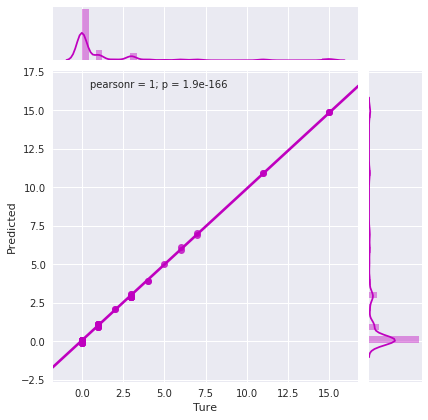

In [16]:
y_rbf=regr.predict(X)

data=pd.DataFrame([y,y_rbf], index=["Ture", "Predicted"])
data=data.T
import seaborn as sns
sns.set(style="darkgrid")

g = sns.jointplot("Ture", "Predicted", data=data, kind="reg",color="m")

## Import Neiborhoods name of Columbus

In [165]:
body = client_3b360455ecb44abbb1f4ec7f31aa7fbf.get_object(Bucket='courseracapstone-donotdelete-pr-dgtrrvtmcmupmq',Key='Columbus_Ohio_Neighborhoods_location.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )



columbus_neighborhoods = pd.read_csv(body)
columbus_neighborhoods.columns=['Neighborhood','Latitude','Longitude']
columbus_neighborhoods.head()

,Neighborhood,Latitude,Longitude
0,Arena District,39.968959,-83.005251
1,Brewery District,39.951159,-83.001111
2,Cassady,39.998355,-82.930182
3,Clintonville,40.052178,-83.009280
4,Discovery District,39.963340,-82.996524


## Explore neighborhoods in Columbus

In [29]:
columbus_venues = getNearbyVenues(names=columbus_neighborhoods['Neighborhood'],
                                   latitudes=columbus_neighborhoods['Latitude'],
                                   longitudes=columbus_neighborhoods['Longitude'],
                                  radius=radius)

Arena District
 Brewery District
 Cassady
 Clintonville
 Discovery District
 Downtown
 Eastland
 Edgewood
 Fifth by Northwest
 Franklinton
 German Village
 Grandview Heights
 Greater Hilltop
 Harrison West
 Holtzman-Main
 Hungarian Village
 Innis Gardens
 Italian Village
 King-Lincoln Bronzeville
 Lincoln Park
 Market Exchange District
 Merion Village
 Mile on High
 Millbrook
 Milo-Grogan
 Near East
 Near South
 North Central
 North East
 North Linden
 Northland
 Northwest
 Old Oaks
 Olde Towne East
 Reeb-Hosack
 RiverSouth District
 Schumacher Place
 Short North
 South Linden
 Southside
 Southwest
 University District
 Untitled Polygon
 Uptown District
 Victorian Village
 Walnut Ridge
 Weinland Park
 West Olentangy
 West Scioto
 Woodland Park


**Let's check the shape of the dataframe**

In [31]:
print(columbus_venues.shape)
columbus_venues.head()

(4869, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arena District,39.968959,-83.005251,Nationwide Arena,39.969135,-83.006098,Hockey Arena
1,Arena District,39.968959,-83.005251,North Market,39.971891,-83.004321,Market
2,Arena District,39.968959,-83.005251,Hilton Columbus Downtown,39.970826,-83.002724,Hotel
3,Arena District,39.968959,-83.005251,Jeni's Splendid Ice Creams,39.971903,-83.004322,Ice Cream Shop
4,Arena District,39.968959,-83.005251,Hot Chicken Takeover,39.971527,-83.004470,Fried Chicken Joint


Let's check how many venues were returned for each neighborhood

In [33]:
columbus_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Brewery District,100,100,100,100,100,100
Cassady,100,100,100,100,100,100
Clintonville,100,100,100,100,100,100
Discovery District,100,100,100,100,100,100
Downtown,100,100,100,100,100,100
Eastland,100,100,100,100,100,100
Edgewood,100,100,100,100,100,100
Fifth by Northwest,100,100,100,100,100,100
Franklinton,100,100,100,100,100,100


**Let's find out how many unique categories can be curated from all the returned venues**

In [34]:
print('There are {} uniques categories.'.format(len(columbus_venues['Venue Category'].unique())))

There are 206 uniques categories.


### 3. Analyze Each Neighborhood

In [35]:
# one hot encoding
columbus_onehot = pd.get_dummies(columbus_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
columbus_onehot['Neighborhood'] = columbus_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [columbus_onehot.columns[-1]] + list(columbus_onehot.columns[:-1])
columbus_onehot = columbus_onehot[fixed_columns]

columbus_onehot.head()

,Neighborhood,ATM,Accessories Store,Airport,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Bavarian Restaurant,Beer Bar,Beer Garden,Big Box Store,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Capitol Building,Caribbean Restaurant,Casino,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dog Run,Donut Shop,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Herbs & Spices Store,History Museum,Hockey Arena,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Optical Shop,Other Great Outdoors,Outdoor Supply Store,Paper / Office Supplies Store,Park,Persian Restaurant,Pet Store,Pharmacy,Piercing Parlor,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Real Estate Office,Record Shop,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Stadium,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Arena District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Arena District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Arena District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0

**Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category**

In [42]:
columbus_grouped = columbus_onehot.groupby('Neighborhood').sum().reset_index()
columbus_grouped.head()

,Neighborhood,ATM,Accessories Store,Airport,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Bavarian Restaurant,Beer Bar,Beer Garden,Big Box Store,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Capitol Building,Caribbean Restaurant,Casino,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dog Run,Donut Shop,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Herbs & Spices Store,History Museum,Hockey Arena,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Optical Shop,Other Great Outdoors,Outdoor Supply Store,Paper / Office Supplies Store,Park,Persian Restaurant,Pet Store,Pharmacy,Piercing Parlor,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Real Estate Office,Record Shop,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Stadium,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Brewery District,0,0,0,0,7,0,0,0,1,1,0,0,0,2,0,2,0,8,0,1,0,1,0,0,0,1,0,0,0,1,4,0,0,1,1,2,0,0,1,0,1,0,0,0,0,0,0,2,5,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,2,0,0,0,0,0,0,1,0,0,0,1,0,2,3,1,0,1,0,0,0,2,0,0,1,0,0,0,0,3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,8,0,0,0,0,2,0,0,0,0,0,1,0,1,0,3,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,1,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,Cassady,0,0,1,1,4,0,1,0,0,0,0,1,0,1,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,0,2,0,0,0,0,1,0,5,0,0,0,0,5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,3,0,0,0,0,0,0,0,0,2,1,0,0,0,0,1,0,0,2,0,1,0,0,0,0,0,0,1,1,1,0,0,0,2,0,0,0,7,0,0,6,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,2,0,7,0,1,1,0,1,1,0,0,0,1,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
2,Clintonville,0,0,0,0,2,1,0,0,0,0,0,1,1,1,0,4,1,3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,2,0,1,4,0,0,0,0,1,0,0,0,2,2,0,0,0,1,1,3,0,0,0,1,0,1,0,0,0,0,0,2,4,1,2,0,1,0,0,0,0,2,0,0,3,0,0,0,1,2,0,

In [39]:
#project.save_data(data=columbus_grouped.to_csv(index=False),file_name='columbus_neighborhood_venues_grouped.csv',overwrite=True)

In [41]:
columbus_grouped[['Neighborhood','Chinese Restaurant']]

,Neighborhood,Chinese Restaurant
0,Brewery District,0
1,Cassady,5
2,Clintonville,0
3,Discovery District,0
4,Downtown,0
5,Eastland,2
6,Edgewood,2
7,Fifth by Northwest,0
8,Franklinton,0
9,German Village,0


### Covert colubus dataframe match templates

In [51]:
template=pd.DataFrame(columns=toronto_grouped.columns)
template=template.merge(columbus_grouped,how='outer')

In [52]:
template.shape

(50, 300)

There maybe some cotogies in Columbus is different from Toronto, so, we will use only catogorys in Toronto dataset

In [59]:
columbus_templated=template[toronto_grouped.columns].copy()
columbus_templated.fillna(0,inplace=True)
columbus_templated.head()

,Neighborhood,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Café,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Malay Restaurant,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pide Place,Pizza Place,Playground,Plaza,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Brewery District,0,0,0,0,7,0,1,0,0,0,0,0,2,0,0,2,0,8,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,4,0,0,0,0,1,1,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,5,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,3,1,0,0,1,0,0,0,2,0,0,1,0,0,0,0,3,0,0,0,0,0,0,

### pridect Chinese restaurant number using Columbus data

In [60]:
X_test=columbus_templated.drop(['Neighborhood','Chinese Restaurant'],axis=1)
y_current=columbus_templated['Chinese Restaurant']

In [70]:
y_predict=regr.predict(X_test)

columbus_data=pd.DataFrame([columbus_templated['Neighborhood'],y_current,y_rbf], index=['Neighborhood',"Current", "Predicted"])
columbus_data=columbus_data.T
columbus_data.set_index('Neighborhood').head()

,Current,Predicted
Neighborhood,,
Brewery District,0,0.00484952
Cassady,5,14.9001
Clintonville,0,14.8996
Discovery District,0,3.10004
Downtown,0,0.0998916


In [85]:
columbus_data.Predicted=columbus_data.Predicted.astype(float).round().astype(int)
columbus_data.head()

,Neighborhood,Current,Predicted,Difference
0,Brewery District,0,0,0.00484952
1,Cassady,5,15,9.90014
2,Clintonville,0,15,14.8996
3,Discovery District,0,3,3.10004
4,Downtown,0,0,0.0998916


**Now we calculated the difference between predict and calculated**

In [86]:
columbus_data['Difference']=columbus_data['Predicted']-columbus_data['Current']
columbus_data.head()

,Neighborhood,Current,Predicted,Difference
0,Brewery District,0,0,0
1,Cassady,5,15,10
2,Clintonville,0,15,15
3,Discovery District,0,3,3
4,Downtown,0,0,0


**Lets sort table by difference,and display the Top 10 neighborhoods**

In [100]:
columbus_data.sort_values('Difference',ascending=False,inplace=True)
columbus_data.head(10)

,Neighborhood,Current,Predicted,Difference
2,Clintonville,0,15,15
42,Uptown District,0,11,11
24,Near East,0,11,11
1,Cassady,5,15,10
18,Lincoln Park,0,7,7
34,RiverSouth District,0,6,6
39,Southwest,0,6,6
3,Discovery District,0,3,3
41,Untitled Polygon,0,3,3
25,Near South,1,3,2


**Lets plot the top 10 recommond neighborhoods**

Text(0,0.5,'# of Chinese Restaurant')

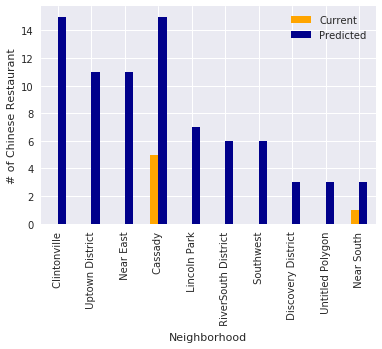

In [140]:
ax=columbus_data.set_index('Neighborhood').iloc[:10,0:2].plot(kind='bar',color=['orange','darkblue'])
ax.set_ylabel("# of Chinese Restaurant")

### Great! we get 10 recommendations of neighborhoods which is suitable for "Chinese restaurant" investment. Pick one of you like and start your Bussiness!

In [142]:
#project.save_data(data=columbus_data.to_csv(index=False),file_name='columbus_neighborhood_results.csv',overwrite=True)

### Finally, let us see where they are on the map

In [167]:
columbus_plot=columbus_data.iloc[:10,:].merge(columbus_neighborhoods,how='left',on='Neighborhood')
columbus_plot

,Neighborhood,Current,Predicted,Difference,Latitude,Longitude
0,Clintonville,0,15,15,40.052178,-83.009280
1,Uptown District,0,11,11,39.963525,-82.999878
2,Near East,0,11,11,39.969941,-82.958221
3,Cassady,5,15,10,39.998355,-82.930182
4,Lincoln Park,0,7,7,39.930358,-82.979725
5,RiverSouth District,0,6,6,39.956022,-83.002564
6,Southwest,0,6,6,39.961176,-82.998794
7,Discovery District,0,3,3,39.963340,-82.996524
8,Untitled Polygon,0,3,3,39.961176,-82.998794
9,Near South,1,3,2,39.890205,-82.950156


In [173]:
# create map of Toronto using latitude and longitude values
columbus_latitude=39.9611755
columbus_longitude=-82.99879420000002

map_columbus = folium.Map(location=[columbus_latitude, columbus_longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(columbus_plot['Latitude'], columbus_plot['Longitude'], columbus_plot['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_columbus) 
    
map_columbus